In [1]:
from platform import python_version
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import user functions
import UserFunctions as uf
import Visualization as vi

# seed
RANDOM_STATE = 1776
# notebook
notebook = '7V1_ML_Per100Days'

# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20


### Import Datasets

In [2]:
# data file
df = pd.read_pickle("../Data/Version1_Consolidated.pkl")

# remove columns
df_remove = pd.read_pickle("../Data/Version1_Consolidated_colRemove.pkl")

# data label
df_label = pd.read_pickle("../Data/Version1_Consolidated_colLabel.pkl")

# don columns
df_don = pd.read_pickle("../Data/Version1_Consolidated_DONColumn.pkl")

# can columns
df_can = pd.read_pickle("../Data/Version1_Consolidated_CANColumn.pkl")

# both columns
df_both = pd.read_pickle("../Data/Version1_Consolidated_BothColumn.pkl")

# nominal columns
df_nominal = pd.read_pickle("../Data/Version1_Consolidated_NominalColumn.pkl")

# ordinal columns
df_ordinal = pd.read_pickle("../Data/Version1_Consolidated_OrdinalColumn.pkl")

# data dictionary
df_dict = pd.read_pickle("../Data/Version1_Consolidated_FinalcolumnDefinition.pkl")

# import flat file
df_flat = pd.read_csv("../Data/flatfile.csv")

# checking for duplicated column name
print(df.columns[df.columns.duplicated()])

Index([], dtype='object')


In [3]:
# import libraries
from sklearn.preprocessing import OrdinalEncoder

def prepDataFrame(data, labelExcludeList, dfDict, dfRemove, dfLabel, dfCan, dfDon, dfBoth, dfOrdinal, dfNominal):
    # display shape of DataFrame
    print(f"Total rows before: {data.shape[0]:,} & columns: {data.shape[1]:,}")
    
    # get remove Features Remove Features
    removeCol = dfRemove.remove.to_list()
    # house keeping
    data, dfDict, dfRemove, dfLabel, dfCan, dfDon, dfBoth, dfOrdinal,  dfNominal = uf.HouseKeeping(data, removeCol, dfDict, dfRemove, \
                                                                                                     dfLabel, dfCan, dfDon, dfBoth,\
                                                                                                     dfOrdinal,  dfNominal, notebook,False)

    # label remove list
    removeCol = dfLabel.label[(~dfLabel.label.isin(labelExcludeList))].to_list()
    # house keeping
    data, dfDict, dfRemove, dfLabel, dfCan, dfDon, dfBoth, dfOrdinal,  dfNominal = uf.HouseKeeping(data, removeCol, dfDict, dfRemove, \
                                                                                                     dfLabel, dfCan, dfDon, dfBoth,\
                                                                                                     dfOrdinal,  dfNominal, notebook,False)


    # display NaNs
    DFNaN = uf.percentageNull(data)
    
    # remove ove 40% NaNs
    removeCol = DFNaN[DFNaN.percentage >= 40].index
    # house keeping
    data, dfDict, dfRemove, dfLabel, dfCan, dfDon, dfBoth, dfOrdinal,  dfNominal = uf.HouseKeeping(data, removeCol, dfDict, dfRemove, \
                                                                                                     dfLabel, dfCan, dfDon, dfBoth,\
                                                                                                     dfOrdinal,  dfNominal, notebook,False)

    # remove all NaNs
    data = data.dropna()

    # resetting the index
    data = data.reset_index(drop=True)

    # remove Zero category from dataframe
    data = uf.removeCatZeroCount(data)

    # display shape of DataFrame
    print(f"Total rows after: {data.shape[0]:,} & columns: {data.shape[1]:,}")    

    # binary categorical features
    binaryCol= [col for col in data.columns if data[col].nunique() == 2]

    # mapp binary features
    mapping = {'N': 1, 'Y':0, 'Yes': 1, 'No': 0, 'Non-Hispanic/Non-Latino': 0, 'Hispanic/Latino': 1, 
               'Negative': 0, 'Not Done': 1, 'True': 0, 'False': 1}

    
    # convert to string
    data[binaryCol] = data[binaryCol].astype(str)
    
    # mapping
    for col in binaryCol:
        data[col] = data[col].map(mapping).fillna(data[col])
    
    # change dataype to integer
    data[binaryCol] = data[binaryCol].astype(int)

    # get ordinal
    ordinalCol = dfOrdinal.ordinal.to_list()
    nominalCol = dfNominal.nominal.to_list()
    
    # BloodGroupMatchLevel
    ordering = ['Identical', 'Compatible', 'Incompatible']
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    data['BloodGroupMatchLevel'] = encoder.fit_transform(data[['BloodGroupMatchLevel']])

    # EducationLevel_CAN
    ordering = ['UNKNOWN', 'NONE', 'GRADE SCHOOL (0-8)','HIGH SCHOOL (9-12) or GED','ATTENDED COLLEGE/TECHNICAL SCHOOL','ASSOCIATE/BACHELOR DEGREE','POST-COLLEGE GRADUATE DEGREE']
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    data['EducationLevel_CAN'] = encoder.fit_transform(data[['EducationLevel_CAN']])    

    # DiabetesType_CAN
    ordering = ['Unknown', 'No', 'Type Unknown', 'Type Other', 'Type II','Type I']
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    data['DiabetesType_CAN'] = encoder.fit_transform(data[['DiabetesType_CAN']])

    # DiabetesHistory_DON
    ordering = ['Unknown', 'No', 'Yes, Duration Unknown','Yes, 0-5 years','Yes, 6-10 years','Yes, >10 years']
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    data['DiabetesHistory_DON'] = encoder.fit_transform(data[['DiabetesHistory_DON']])

    # CigaretteAbstinence_CAN
    ordering = ['Unknown', 'Unknown duration', '0-2 months', '3-12 months','13-24 months', '25-36 months', '37-48 months', '49-60 months', '>60 months', 'Continues to smoke']
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    data['CigaretteAbstinence_CAN'] = encoder.fit_transform(data[['CigaretteAbstinence_CAN']])

    # MedicalConditionTransplant_CAN
    ordering = ['Unknown', 'Not Hospitalized', 'Hospitalized Not in ICU', 'In Intensive Care Unit']
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    data['MedicalConditionTransplant_CAN'] = encoder.fit_transform(data[['MedicalConditionTransplant_CAN']])

    # MismatchLevel_LOCUS
    ordering = ['Unknown', 'Low Mismatch', 'High Mismatch']
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    data['MismatchLevel_LOCUS'] = encoder.fit_transform(data[['MismatchLevel_LOCUS']])

    # MismatchLevel_HLA
    ordering = ['Unknown', 'No Mismatch', 'Low Mismatch', 'Moderate Mismatch', 'High Mismatch']
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    data['MismatchLevel_HLA'] = encoder.fit_transform(data[['MismatchLevel_HLA']])

    # MismatchLevel_B_LOCUS
    ordering = ['Unknown', 'Low Mismatch', 'High Mismatch']
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    data['MismatchLevel_B_LOCUS'] = encoder.fit_transform(data[['MismatchLevel_B_LOCUS']])

    # MismatchLevel_DR_LOCUS
    ordering = ['Unknown', 'Low Mismatch', 'High Mismatch']
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    data['MismatchLevel_DR_LOCUS'] = encoder.fit_transform(data[['MismatchLevel_DR_LOCUS']])

    # TransfusionNumber_DON
    ordering = ['NONE', '1 - 5', '6 - 10', 'GREATER THAN 10']
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    data['TransfusionNumber_DON'] = encoder.fit_transform(data[['TransfusionNumber_DON']])

    # CalculatedPanelReactiveAntibody_CPRA_CAN_Mean
    ordering = ['Unknown', 'No Sensitization', 'Low Sensitization', 'Moderate Sensitization', 'High Sensitization']
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    data['CalculatedPanelReactiveAntibody_CPRA_CAN_Mean'] = encoder.fit_transform(data[['CalculatedPanelReactiveAntibody_CPRA_CAN_Mean']])

    # FunctionalStatusTransplant_Combined_CAN
    ordering = ['Unknown', 'Functional', 'Limited', 'Critical']
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    data['FunctionalStatusTransplant_Combined_CAN'] = encoder.fit_transform(data[['FunctionalStatusTransplant_Combined_CAN']])

    # return each list of datatypes
    numericCols = list(set(data.columns.to_list()) - set(nominalCol).union(set(binaryCol)).union(set(ordinalCol)))
    ordinalCols = ordinalCol.copy()
    nominalCols = list(set(nominalCol) - (set(binaryCol) | set(ordinalCol)))
    binaryCols  = binaryCol.copy()
    # display
    print(f"\nTotal number of Numeric Features: {len(numericCols)}")
    print(f"Total number of Ordinal Features: {len(ordinalCols)}")
    print(f"Total number of Nominal Features: {len(nominalCols)}")
    print(f"Total number of Binary Features: {len(binaryCols)}")
    print(f"\nTotal number of Combined Features: {len(numericCols) + len(ordinalCols) + len(nominalCols) + len(binaryCols)}")

    return data, numericCols, ordinalCols, nominalCols, binaryCols

### Wrangle Data

In [4]:
# labels
labelExcludeList = ['TransplantStatus','TransplantSurvivalDay']

# cleaned data & feature list
df_cleaned, numericCols, ordinalCols, nominalCols, binaryCols  = prepDataFrame(df, labelExcludeList, df_dict, df_remove, df_label, df_can, df_don, df_both, df_ordinal, df_nominal)

Total rows before: 15,284 & columns: 250
Total rows after: 13,330 & columns: 139

Total number of Numeric Features: 18
Total number of Ordinal Features: 32
Total number of Nominal Features: 69
Total number of Binary Features: 20

Total number of Combined Features: 139


#### Heatmap 

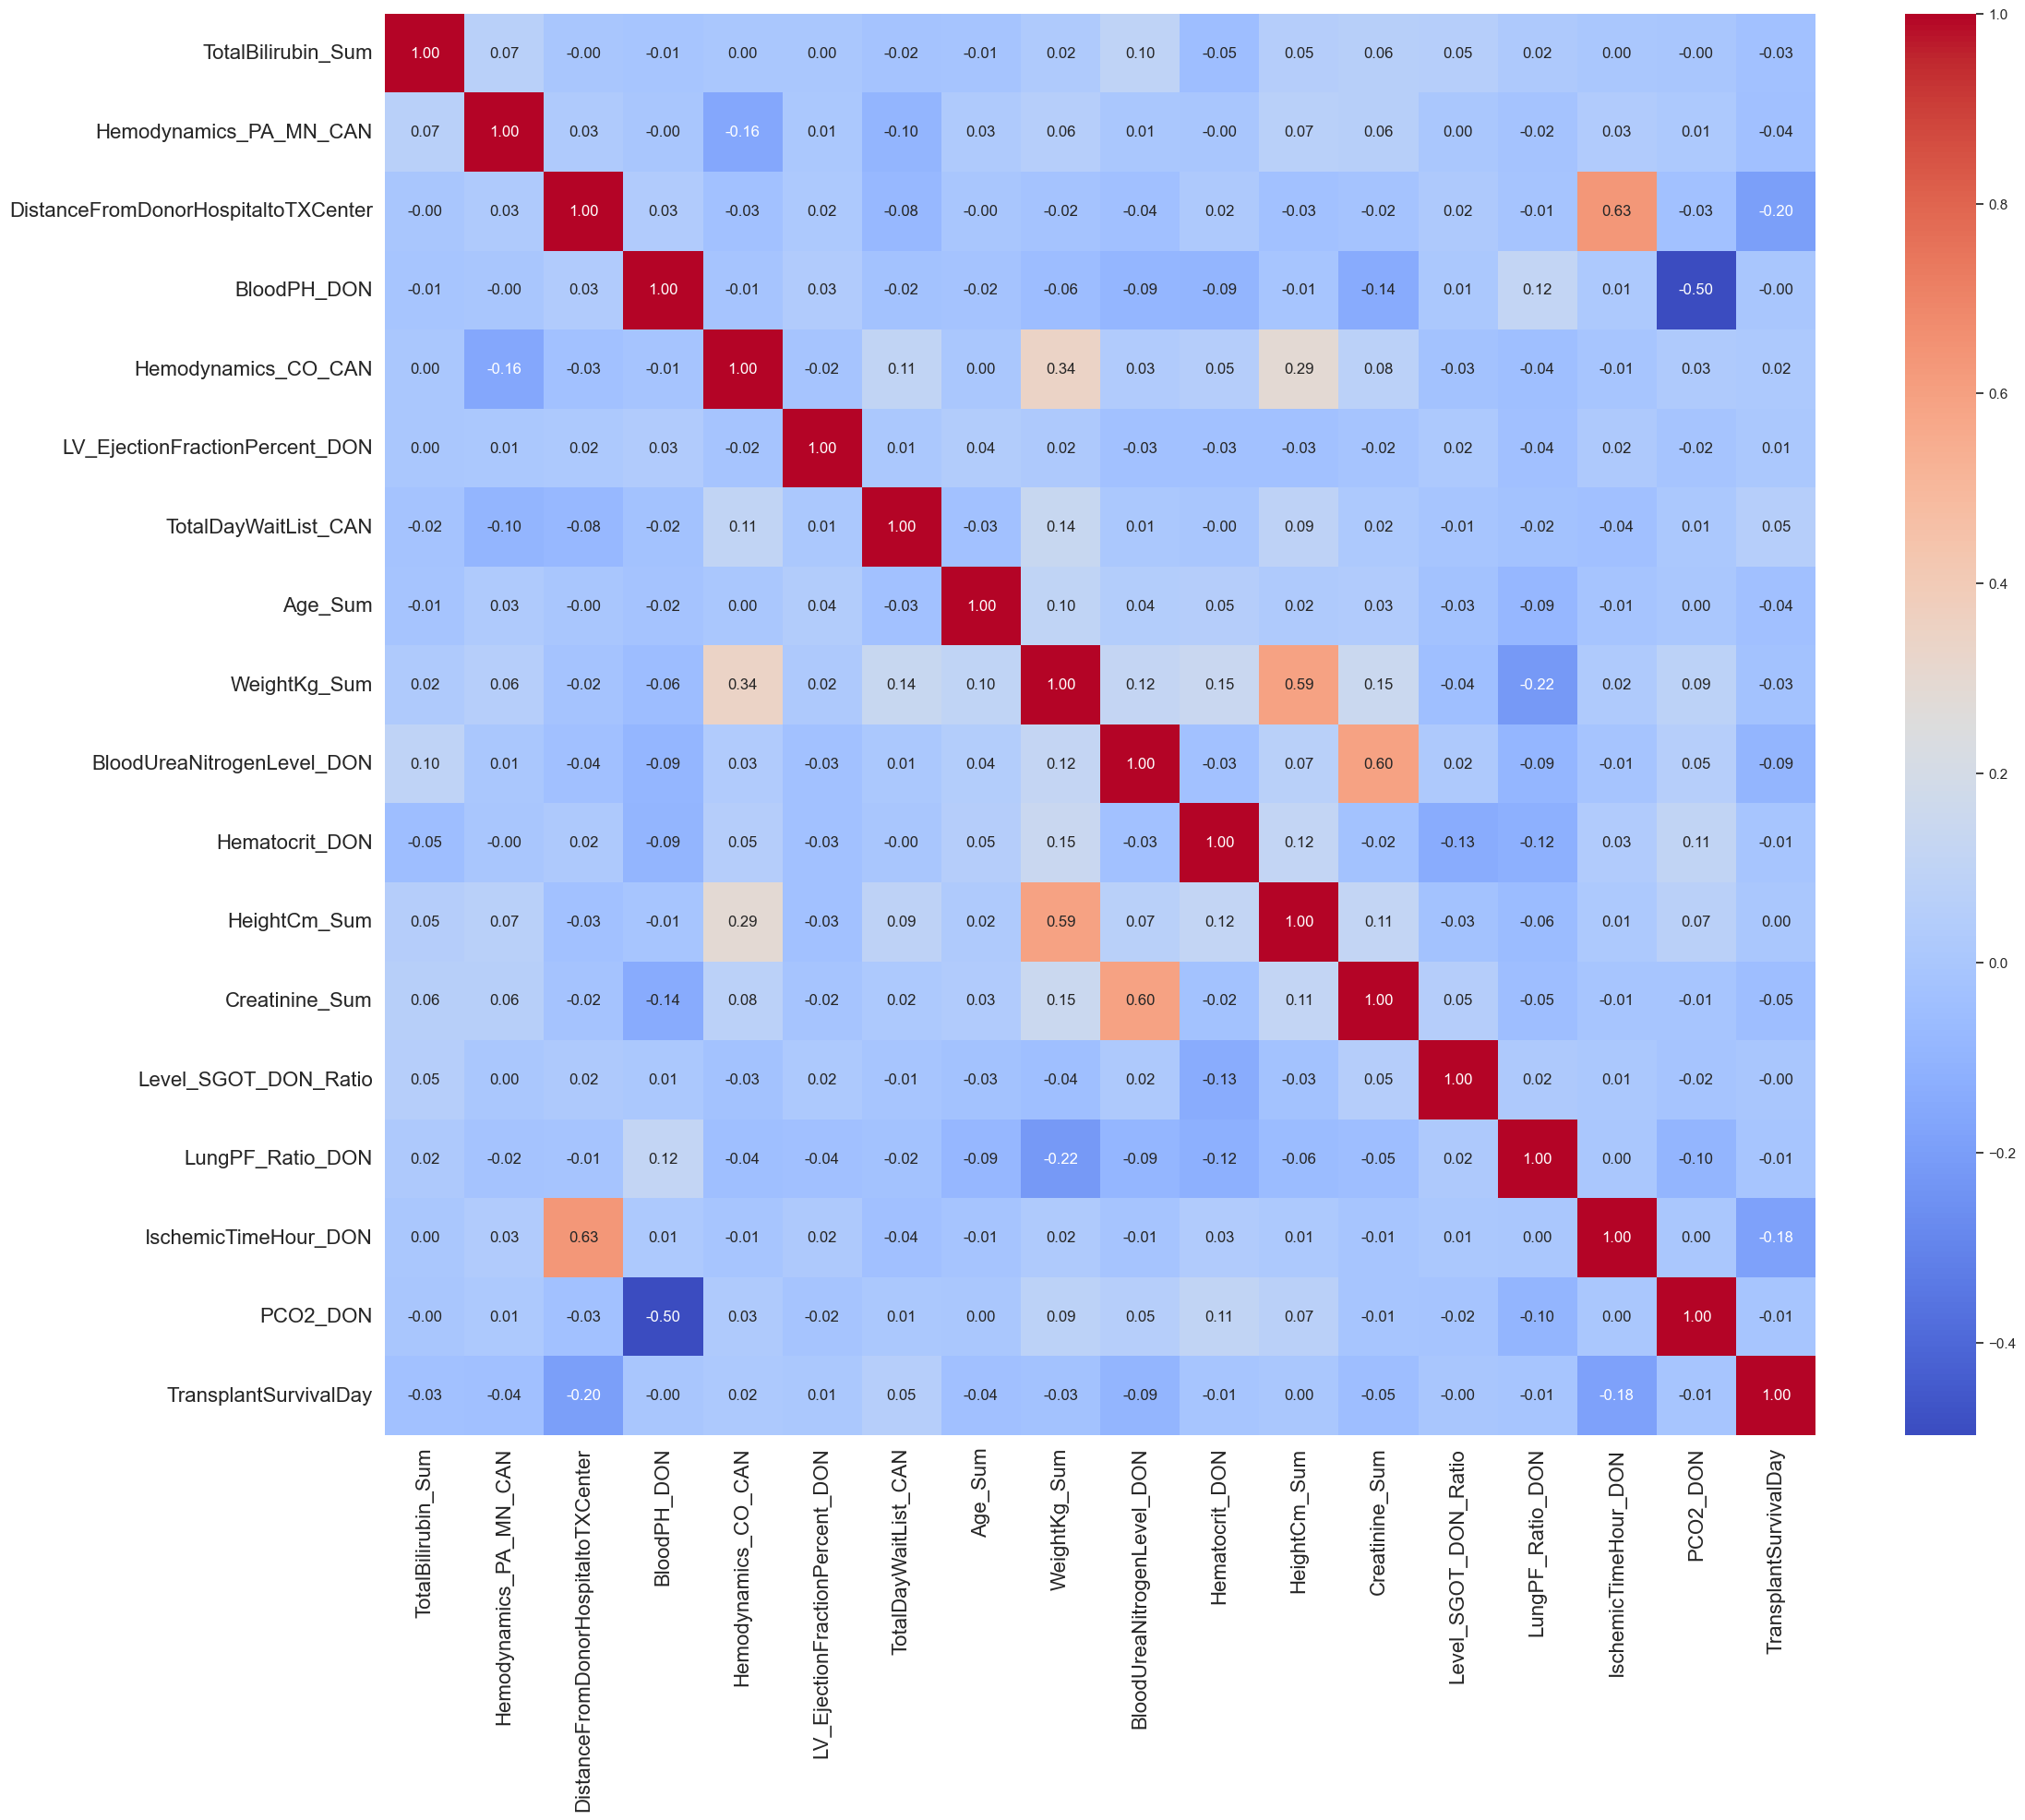

In [5]:
plt.figure(figsize=(25, 20))
sns.heatmap(df_cleaned[numericCols].corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#### Determine Candidate Survival for 100 Days Increment

In [6]:
# import library
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# 100 days increment
days = list(range(100, 1600, 100))
# copy datafram
df_process = df_cleaned.copy()

# iterate
for day in days:
    # create new feature
    df_process['Survival'] = (df_process.TransplantSurvivalDay >= day)
    # remove unwanted labels
    df_process = df_process.drop(columns=labelExcludeList, axis=1)
    # dummy Encoding
    df_encoded = pd.get_dummies(df_process, columns=nominalCols, drop_first=True, dtype=int)

    # entire features
    X = df_encoded.drop('Survival', axis=1)
    y = df_encoded['Survival']

    # identify and drop low variance columns
    low_variance_cols = [col for col in X.columns if X[col].var() < 0.01]
    # drop features
    X = X.drop(columns=low_variance_cols, axis=1)

    # split the dataset into 80% training and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    # get SelectKBest info
    selectedDF = uf.selectKClassif(X_train, y_train, K='all', function='f_classif')

    # select p_value <= 0.05
    selected = selectedDF.Feature[selectedDF.p_value <= 0.05].to_list() 

    # the 'balanced' mode adjusts weights inversely proportional to class frequencies in the input data for Random Forest
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))

    # grid search Hyperparameters Random Forest Classfiier
    parameters = {
        'n_estimators': [100, 300, 500],
        'min_samples_split': [30, 40, 50],
        'min_samples_leaf': [8, 10, 15],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [5, 7]
    }
    
    # Initialize Model with class weights
    rfc_param = {'class_weight': class_weight_dict, 'random_state': RANDOM_STATE}
    
    # instantiate Random Forest Classifier
    model = RandomForestClassifier(**rfc_param)
    
    # CV with grid search for Hyper-Parameter tuning
    rfc_GS_fit = uf.stratified_grid(model, parameters, X_train[selected], y_train, nJobs=-1, nSplit=5, score = 'f1')
    
    # best model
    model = rfc_GS_fit.best_estimator_ 
    # display model
    print(model)
    
    # initialize variables
    Algorithm = 'RandomForestClassifier'
    Desc = f'RandomForestClassifier - Grid Search {day} days- Features where p_value <= 0.05'
    Model = 'rfc_GS_fit'
    Type = 'Training'

    if day == 100:
        # display
        df_classfication = uf.ClassificationMatric(Algorithm, Model, Desc, model, X_train[selected], y_train, Type, metricDF=None, display=False)
        Type = 'Testing'
        df_classfication = uf.ClassificationMatric(Algorithm, Model, Desc, model, X_test[selected], y_test, Type, metricDF=df_classfication, display=False)
    else:
        df_classfication = uf.ClassificationMatric(Algorithm, Model, Desc, model, X_train[selected], y_train, Type, metricDF=df_classfication, display=False)
        Type = 'Testing'
        df_classfication = uf.ClassificationMatric(Algorithm, Model, Desc, model, X_test[selected], y_test, Type, metricDF=df_classfication, display=False)
    # reset current file
    df_process = df_cleaned.copy()

CV accuracy: 0.768 +/- 0.011
RandomForestClassifier(class_weight={False: 3.3366708385481854,
                                     True: 0.5881314802559011},
                       max_depth=7, min_samples_leaf=8, min_samples_split=30,
                       random_state=1776)
CV accuracy: 0.688 +/- 0.007


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestClassifier(class_weight={False: 1.9523983888685463,
                                     True: 0.6721290810538257},
                       max_depth=7, max_features='log2', min_samples_leaf=8,
                       min_samples_split=30, n_estimators=300,
                       random_state=1776)
CV accuracy: 0.680 +/- 0.006


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestClassifier(class_weight={False: 1.7726063829787233,
                                     True: 0.6964472309299895},
                       max_depth=7, max_features='log2', min_samples_leaf=10,
                       min_samples_split=40, n_estimators=300,
                       random_state=1776)
CV accuracy: 0.721 +/- 0.012


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestClassifier(class_weight={False: 1.055841584158416,
                                     True: 0.9497684360527253},
                       max_depth=7, min_samples_leaf=8, min_samples_split=40,
                       random_state=1776)
CV accuracy: 0.723 +/- 0.008


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestClassifier(class_weight={False: 1.0251874639492404,
                                     True: 0.9760205015559217},
                       max_depth=7, min_samples_leaf=8, min_samples_split=30,
                       n_estimators=300, random_state=1776)
CV accuracy: 0.723 +/- 0.005


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestClassifier(class_weight={False: 1.0024440684339162,
                                     True: 0.9975678203928906},
                       max_depth=7, min_samples_leaf=10, min_samples_split=30,
                       random_state=1776)
CV accuracy: 0.737 +/- 0.007


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestClassifier(class_weight={False: 0.9351104875482287,
                                     True: 1.0745667069729947},
                       max_depth=7, min_samples_leaf=8, min_samples_split=40,
                       n_estimators=300, random_state=1776)
CV accuracy: 0.864 +/- 0.006


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestClassifier(class_weight={False: 0.7350427350427351,
                                     True: 1.5636363636363637},
                       max_depth=7, min_samples_leaf=8, min_samples_split=40,
                       random_state=1776)
CV accuracy: 0.855 +/- 0.009


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestClassifier(class_weight={False: 0.7266285091305533,
                                     True: 1.603126879134095},
                       max_depth=7, min_samples_leaf=10, min_samples_split=50,
                       random_state=1776)
CV accuracy: 0.835 +/- 0.009


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestClassifier(class_weight={False: 0.7085714285714285,
                                     True: 1.6986301369863013},
                       max_depth=7, min_samples_leaf=8, min_samples_split=50,
                       n_estimators=500, random_state=1776)
CV accuracy: 0.697 +/- 0.014


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestClassifier(class_weight={False: 0.6239176222794289,
                                     True: 2.5174693106704438},
                       max_depth=7, min_samples_leaf=8, min_samples_split=50,
                       n_estimators=500, random_state=1776)
CV accuracy: 0.752 +/- 0.021


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestClassifier(class_weight={False: 0.5839448034169313,
                                     True: 3.478147423352903},
                       max_depth=7, min_samples_leaf=8, min_samples_split=30,
                       random_state=1776)
CV accuracy: 0.743 +/- 0.014


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestClassifier(class_weight={False: 0.5790616854908774,
                                     True: 3.662087912087912},
                       max_depth=7, max_features='log2', min_samples_leaf=8,
                       min_samples_split=30, n_estimators=300,
                       random_state=1776)
CV accuracy: 0.667 +/- 0.013


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestClassifier(class_weight={False: 0.5646510642804193,
                                     True: 4.366912366912367},
                       max_depth=7, min_samples_leaf=8, min_samples_split=50,
                       random_state=1776)
CV accuracy: 0.051 +/- 0.010
RandomForestClassifier(class_weight={False: 0.5023080546396609,
                                     True: 108.81632653061224},
                       max_depth=7, min_samples_leaf=15, min_samples_split=50,
                       random_state=1776)


In [7]:
df_classfication

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_GS_fit,RandomForestClassifier - Grid Search 100 days- Features where p_value <= 0.05,Training,0.689422,0.681447,0.788614,0.908500,0.935777,0.734668,0.708058
1,RandomForestClassifier,rfc_GS_fit,RandomForestClassifier - Grid Search 100 days- Features where p_value <= 0.05,Testing,0.640660,0.650927,0.754862,0.881423,0.898295,0.582500,0.616713
2,RandomForestClassifier,rfc_GS_fit,RandomForestClassifier - Grid Search 200 days- Features where p_value <= 0.05,Training,0.633627,0.568889,0.697905,0.834185,0.902600,0.821677,0.695283
3,RandomForestClassifier,rfc_GS_fit,RandomForestClassifier - Grid Search 200 days- Features where p_value <= 0.05,Testing,0.639910,0.580434,0.705702,0.834423,0.899922,0.812592,0.696513
4,RandomForestClassifier,rfc_GS_fit,RandomForestClassifier - Grid Search 300 days- Features where p_value <= 0.05,Training,0.641692,0.571186,0.695950,0.816471,0.890450,0.821144,0.696165
5,RandomForestClassifier,rfc_GS_fit,RandomForestClassifier - Grid Search 300 days- Features where p_value <= 0.05,Testing,0.631283,0.559561,0.685440,0.811076,0.884393,0.813830,0.686695
6,RandomForestClassifier,rfc_GS_fit,RandomForestClassifier - Grid Search 400 days- Features where p_value <= 0.05,Training,0.755720,0.627182,0.729968,0.743827,0.873047,0.898614,0.762898
7,RandomForestClassifier,rfc_GS_fit,RandomForestClassifier - Grid Search 400 days- Features where p_value <= 0.05,Testing,0.758065,0.653599,0.739814,0.739313,0.852230,0.874109,0.763854
8,RandomForestClassifier,rfc_GS_fit,RandomForestClassifier - Grid Search 500 days- Features where p_value <= 0.05,Training,0.757502,0.632070,0.727560,0.730192,0.857036,0.889252,0.760661
9,RandomForestClassifier,rfc_GS_fit,RandomForestClassifier - Grid Search 500 days- Features where p_value <= 0.05,Testing,0.766317,0.654466,0.741601,0.736941,0.855502,0.883846,0.769156


In [10]:
# extract number of days only from description feature
df_classfication['Info'] = df_classfication['Description'].str.extract(r'((\d+) days)')[0]

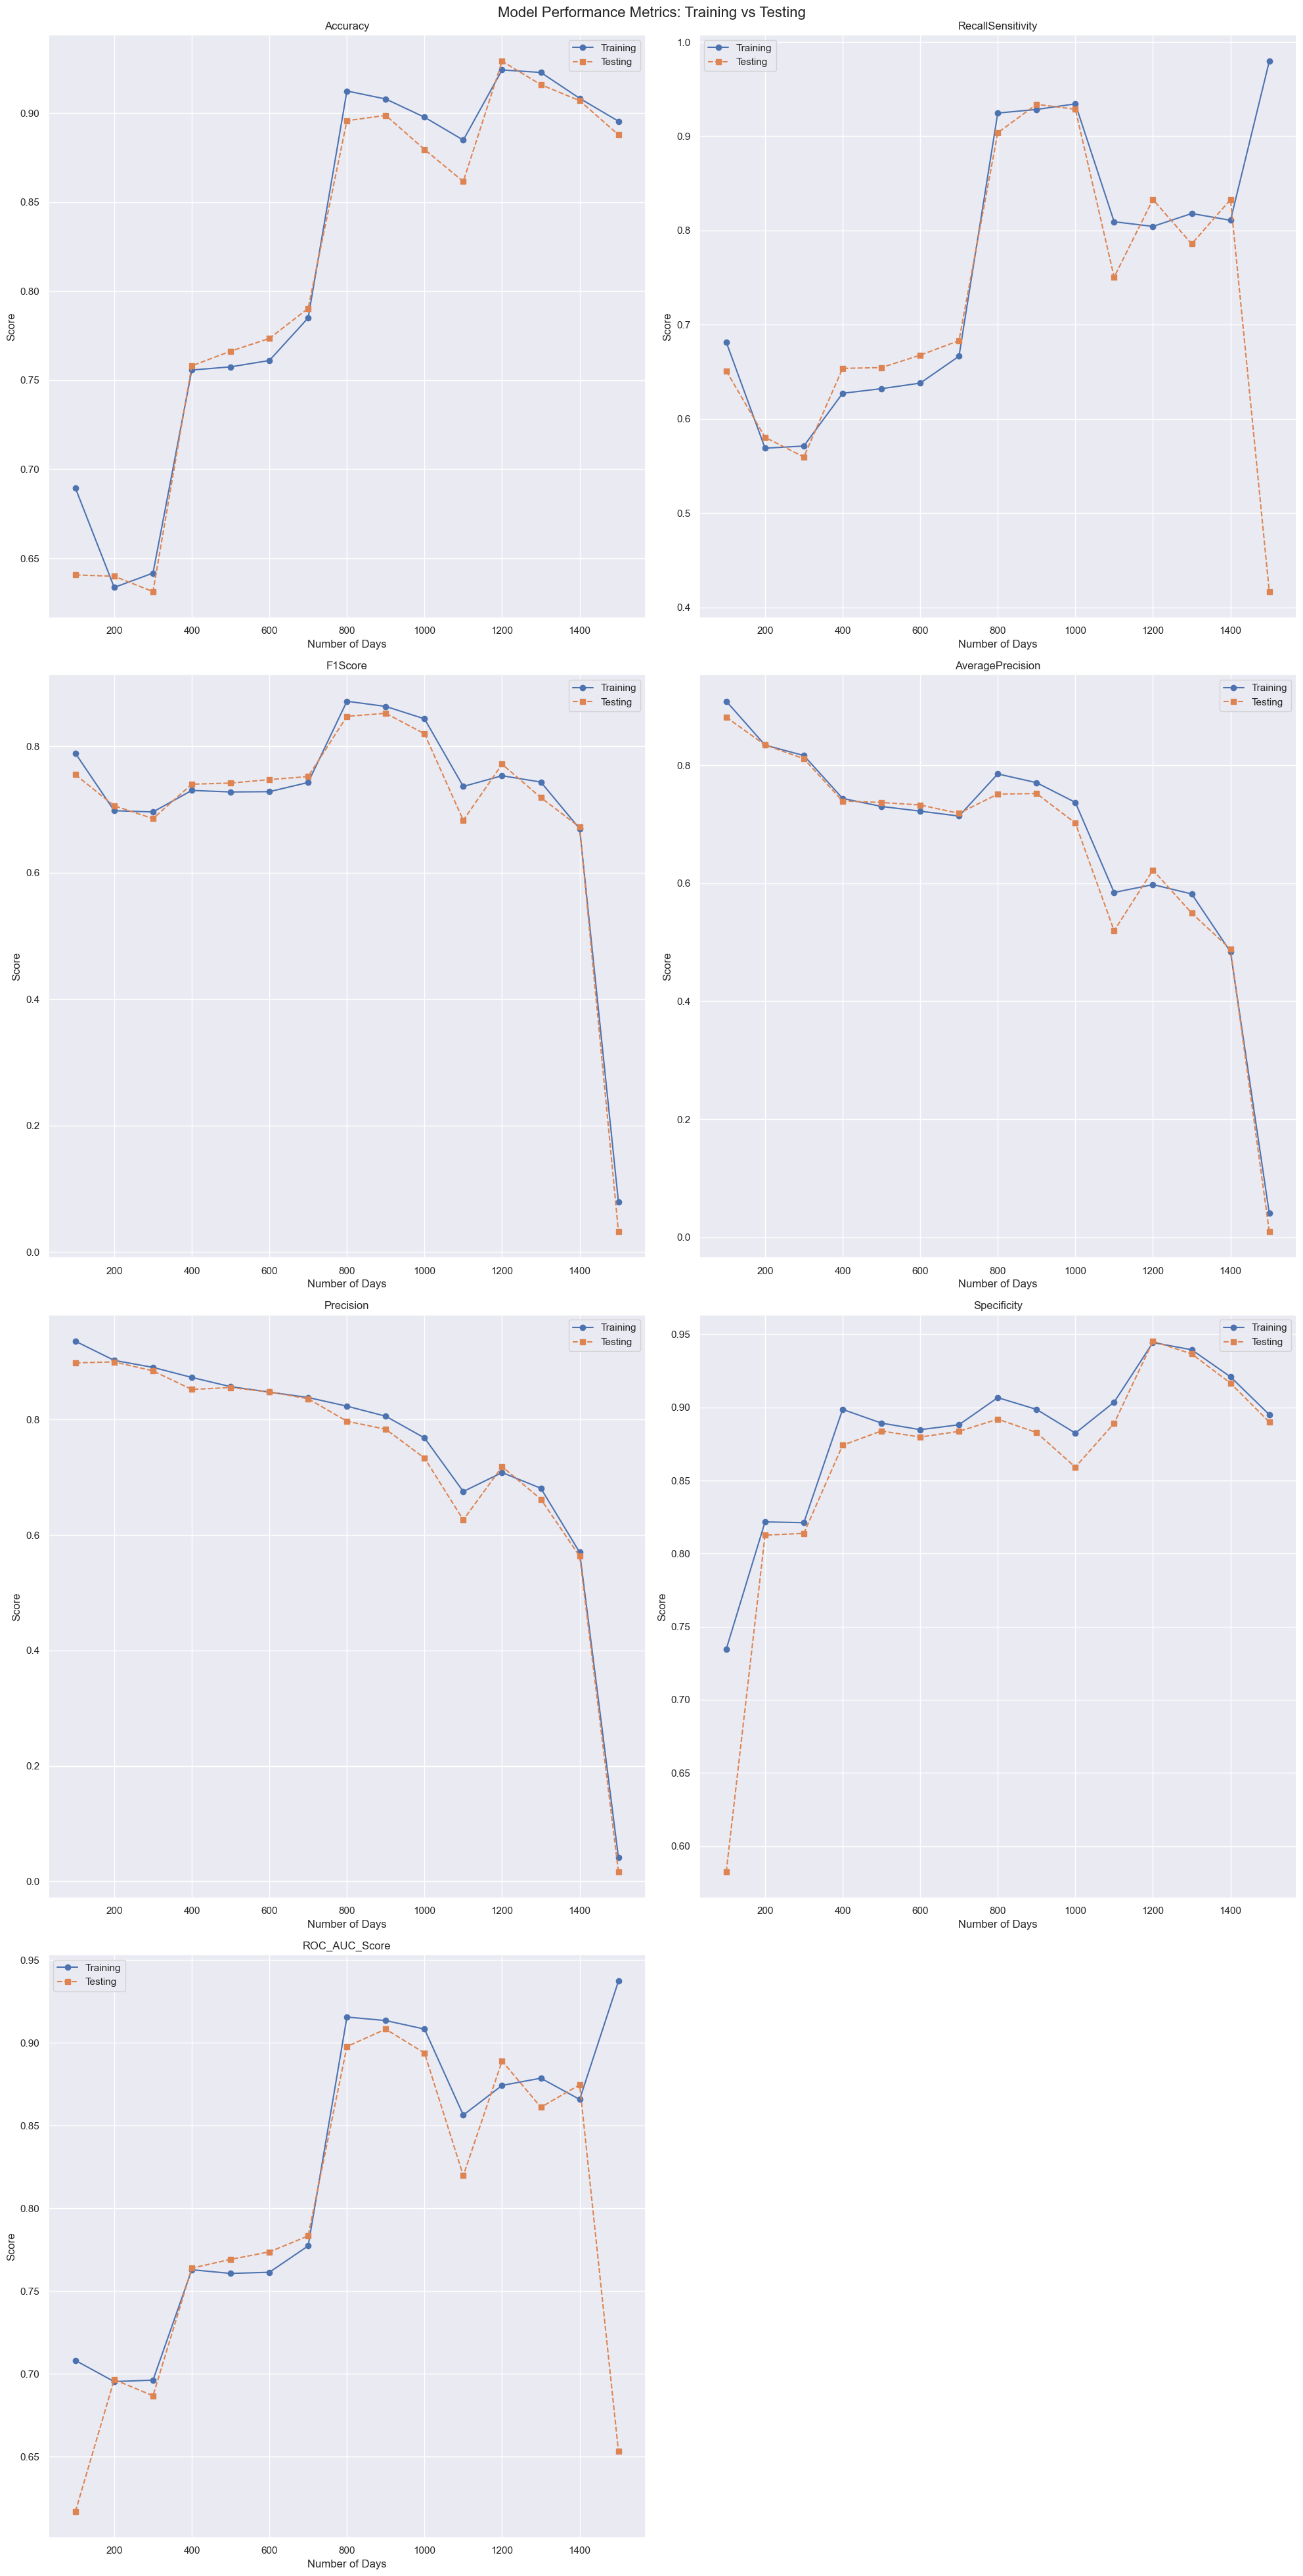

In [13]:
# Dynamically get all metrics (excluding specified columns)
metrics = [col for col in df_classfication.columns if col not in ['Algorithm','Model','Description','DataType','Info']]

# Calculate the number of rows and columns for subplots
n_metrics = len(metrics)
n_cols = min(2, n_metrics)  # Max 2 columns
n_rows = int(np.ceil(n_metrics / n_cols))  # Using np.ceil and converting to int

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 10*n_rows))
fig.suptitle('Model Performance Metrics: Training vs Testing\n\n', fontsize=16)

# Flatten axes array for easier indexing
axes = axes.flatten() if n_metrics > 1 else [axes]

for i, metric in enumerate(metrics):
    ax = axes[i]
    for data_type, linestyle, marker in [('Training', '-', 'o'), ('Testing', '--', 's')]:
        data = df_classfication[df_classfication['DataType'] == data_type]
        ax.plot(data['Info'].str.replace(' days', '').astype(int), data[metric], 
                linestyle=linestyle, marker=marker, label=f'{data_type}')
    
    ax.set_xlabel('Number of Days')
    ax.set_ylabel('Score')
    ax.set_title(metric)
    ax.legend()
    ax.grid(True)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()